In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/My Drive/fake_job_postings.csv')

In [4]:
print(train_df.shape)

(17880, 18)


In [ ]:
# @title
print(train_df.describe)

<bound method NDFrame.describe of        job_id                                              title  \
0           1                                   Marketing Intern   
1           2          Customer Service - Cloud Video Production   
2           3            Commissioning Machinery Assistant (CMA)   
3           4                  Account Executive - Washington DC   
4           5                                Bill Review Manager   
...       ...                                                ...   
17875   17876                   Account Director - Distribution    
17876   17877                                 Payroll Accountant   
17877   17878  Project Cost Control Staff Engineer - Cost Con...   
17878   17879                                   Graphic Designer   
17879   17880                         Web Application Developers   

                   location   department salary_range  \
0          US, NY, New York    Marketing          NaN   
1            NZ, , Auckland      Su

In [ ]:
# @title
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

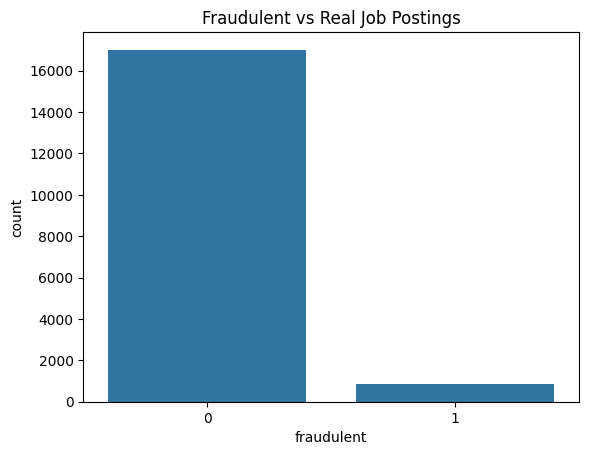

fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64


In [ ]:
# @title
sns.countplot(data=train_df, x="fraudulent")
plt.title("Fraudulent vs Real Job Postings")
plt.show()

print(train_df["fraudulent"].value_counts(normalize=True)*100)

<Axes: >

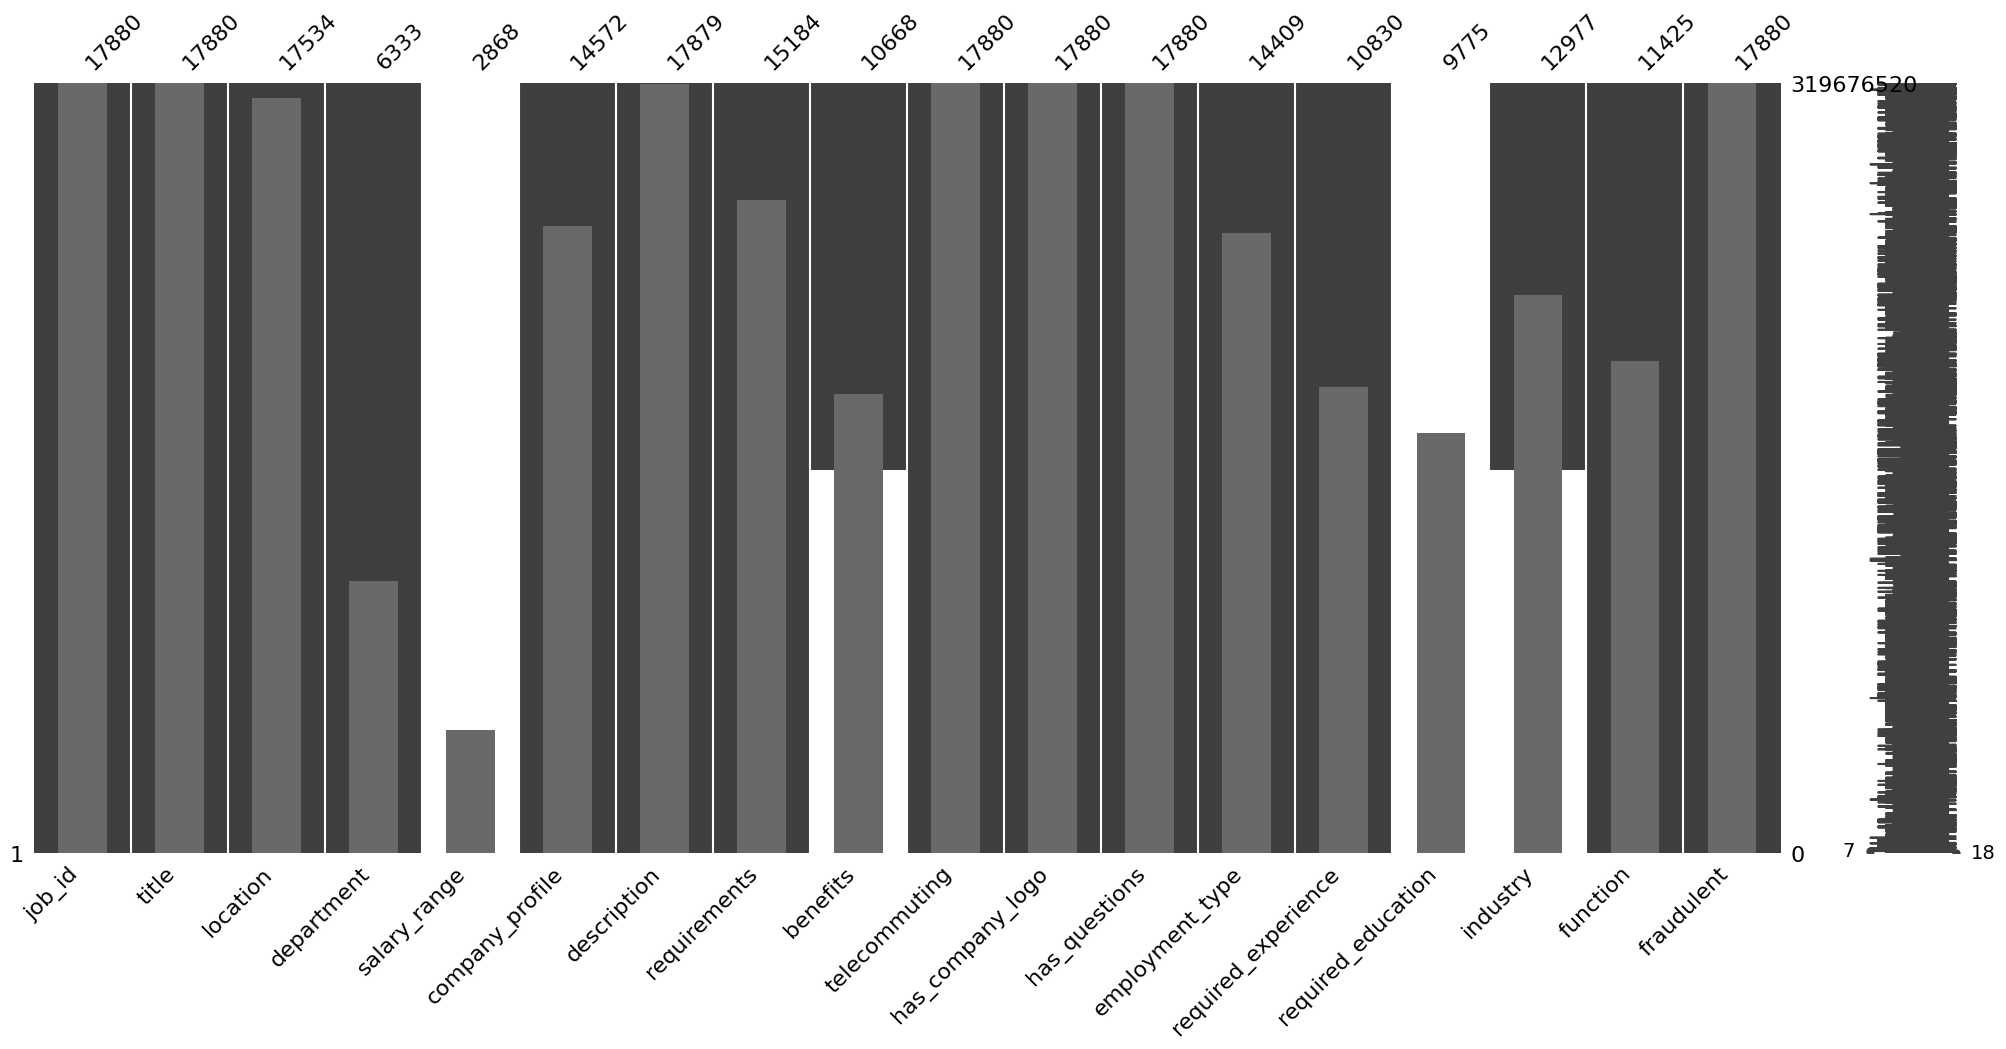

In [ ]:
# @title
msno.matrix(train_df)
msno.bar(train_df)

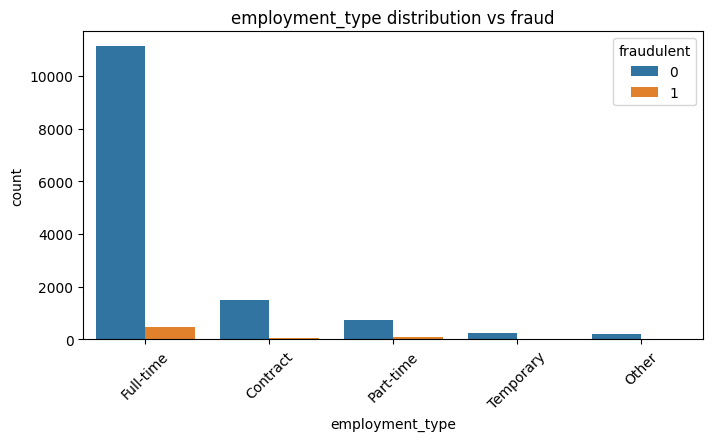

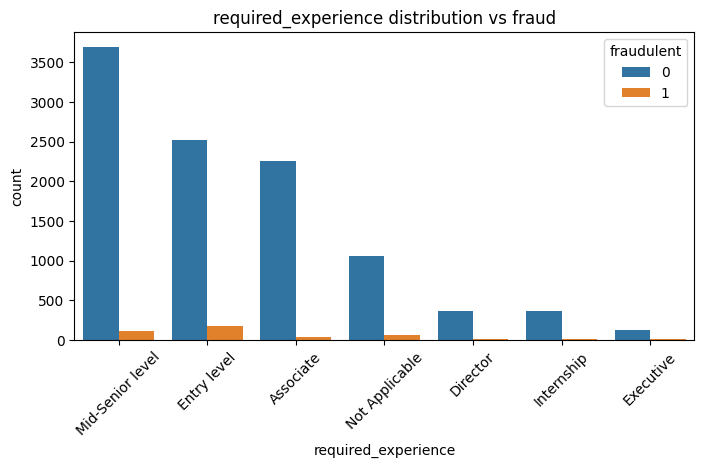

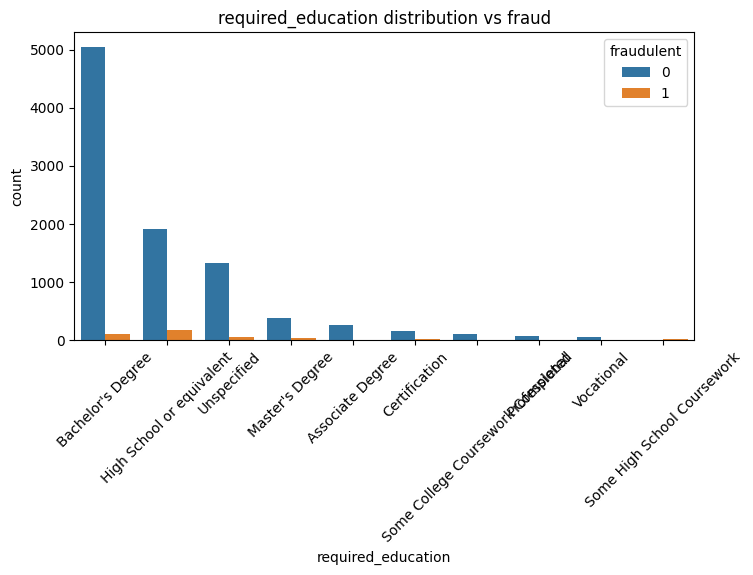

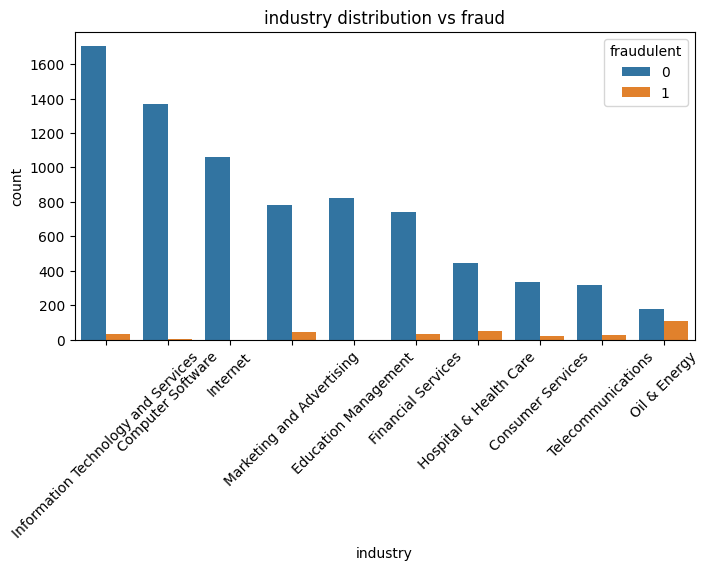

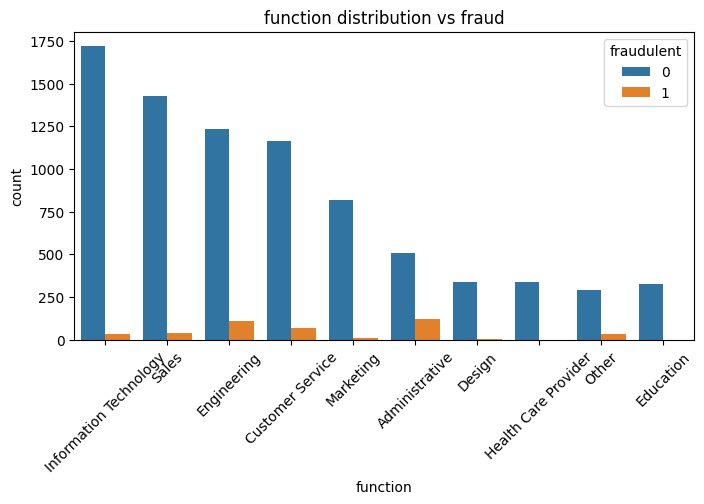

In [ ]:
# @title
categoricals = ["employment_type", "required_experience", "required_education", "industry", "function"]

for col in categoricals:
    plt.figure(figsize=(8,4))
    sns.countplot(data=train_df, x=col, hue="fraudulent", order=train_df[col].value_counts().index[:10])
    plt.xticks(rotation=45)
    plt.title(f"{col} distribution vs fraud")
    plt.show()

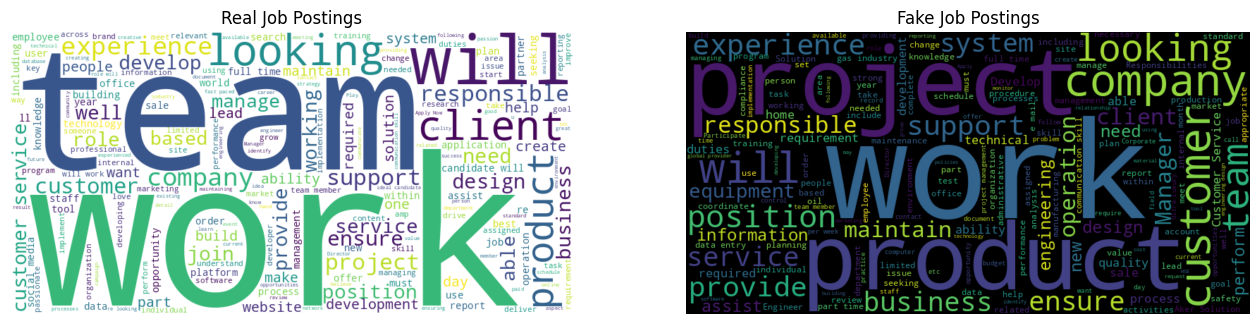

In [ ]:
# @title
real_desc = " ".join(train_df[train_df["fraudulent"]==0]["description"].dropna().astype(str))
fake_desc = " ".join(train_df[train_df["fraudulent"]==1]["description"].dropna().astype(str))

real_wc = WordCloud(width=800, height=400, background_color="white").generate(real_desc)
fake_wc = WordCloud(width=800, height=400, background_color="black").generate(fake_desc)

# Plot side by side
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(real_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Real Job Postings")

plt.subplot(1,2,2)
plt.imshow(fake_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Fake Job Postings")

plt.show()

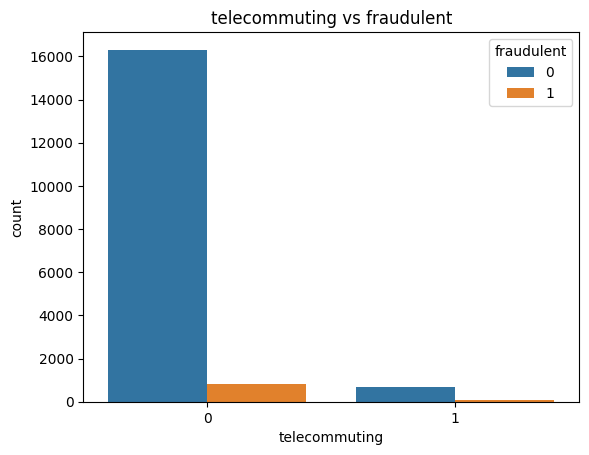

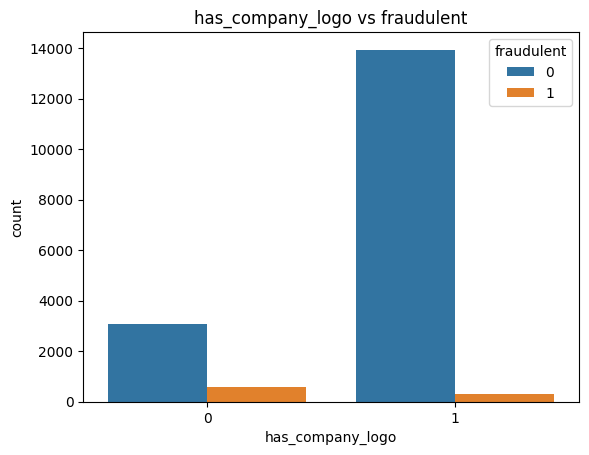

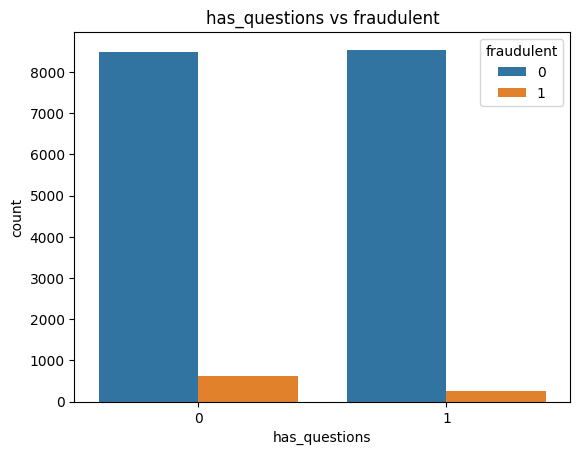

In [ ]:
# @title
binary_cols = ["telecommuting", "has_company_logo", "has_questions"]

for col in binary_cols:
    sns.countplot(data=train_df, x=col, hue="fraudulent")
    plt.title(f"{col} vs fraudulent")
    plt.show()

<Axes: >

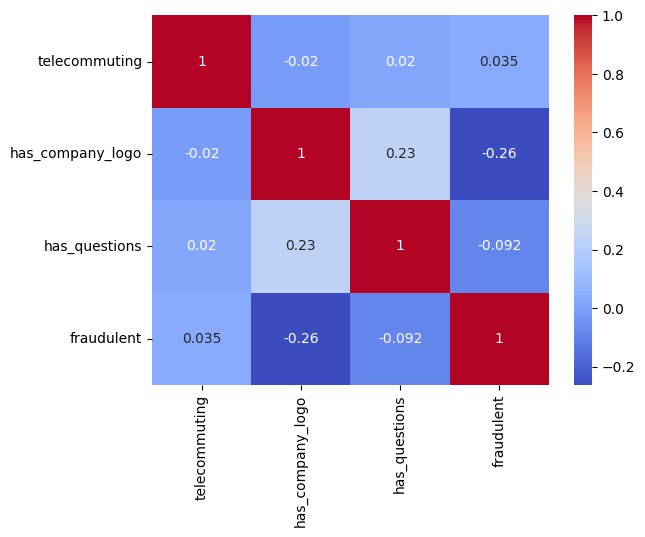

In [ ]:
# @title
sns.heatmap(train_df[["telecommuting", "has_company_logo", "has_questions", "fraudulent"]].corr(), annot=True, cmap="coolwarm")


In [ ]:
# @title
train_df["text"] = (
    train_df["title"].fillna("") + " " +
    train_df["description"].fillna("") +
    train_df["requirements"].fillna("")
)
X = train_df["text"]
y = train_df["fraudulent"]

In [ ]:
# @title
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# @title
tfidf = TfidfVectorizer(stop_words="english", max_features=15000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# @title
tfidf = TfidfVectorizer(stop_words='english', max_features=None, ngram_range=(1,2))
tfidf.fit(X_train)

print("Full vocab size:", len(tfidf.vocabulary_))

Full vocab size: 346014


In [ ]:
# @title
lasso = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    C=1,
    max_iter=200
)

In [ ]:
# @title
lasso.fit(X_train_tfidf, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=200, penalty='l1',
                   solver='liblinear')

In [ ]:
# @title
y_pred = lasso.predict(X_test_tfidf)
y_proba = lasso.predict_proba(X_test_tfidf)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      3403
           1       0.50      0.80      0.62       173

    accuracy                           0.95      3576
   macro avg       0.75      0.88      0.80      3576
weighted avg       0.97      0.95      0.96      3576

ROC-AUC Score: 0.9588088714649943


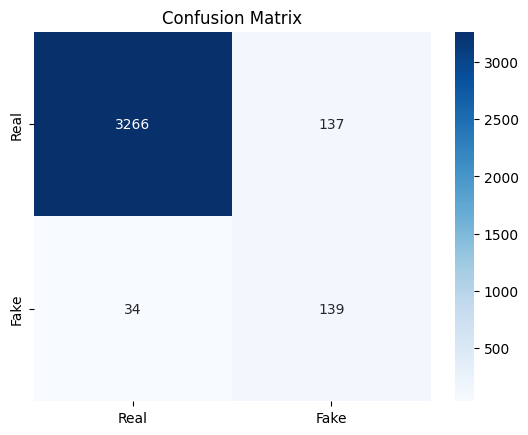

In [ ]:
# @title
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"],
            yticklabels=["Real","Fake"])
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# @title
importance = pd.DataFrame({
    "feature": tfidf.get_feature_names_out(),
    "coef": lasso.coef_[0]
})

top_fake = importance.sort_values("coef", ascending=False).head(20)
top_real = importance.sort_values("coef", ascending=True).head(20)

print("\nTop words indicating FAKE postings:\n", top_fake)
print("\nTop words indicating REAL postings:\n", top_real)



Top words indicating FAKE postings:
                   feature       coef
7480    line requirements  31.075744
7488                 link  23.273519
3707   development mobile  18.888097
6116          high school  17.629060
14668           work home  16.476390
14381               wages  14.579161
7155   knowledge required  14.296789
14788       working sales  13.871698
3228           data entry  12.947781
3047               cruise  12.365420
6144     highly desirable  12.305094
2150                clerk  11.676342
6563      industry trends  11.640871
609                 aecom  11.418323
2323           collateral  11.216184
695                 align  11.080758
12205               sites  11.061398
10444          properties  10.482591
6197           home based  10.435460
8947             offshore  10.350534

Top words indicating REAL postings:
             feature       coef
4387        english -21.634013
153              50 -14.950976
12721         state -12.511898
7696           love -11

In [ ]:
categorical_features = ["employment_type", "required_experience", "required_education", "industry", "function"]

# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# encoded = encoder.fit_transform(train_df[categorical_features])
# encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))


In [ ]:
categorical_features = ["employment_type", "required_experience", "required_education", "industry", "function"]

# Dictionary to store mappings
mappings = {}

for col in categorical_features:
    unique_vals = train_df[col].unique()  # get unique values ignoring NaNs
    print(f"Unique values in {col}:")
    print(unique_vals)

Unique values in employment_type:
['Other' 'Full-time' nan 'Part-time' 'Contract' 'Temporary']
Unique values in required_experience:
['Internship' 'Not Applicable' nan 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']
Unique values in required_education:
[nan "Bachelor's Degree" "Master's Degree" 'High School or equivalent'
 'Unspecified' 'Some College Coursework Completed' 'Vocational'
 'Certification' 'Associate Degree' 'Professional' 'Doctorate'
 'Some High School Coursework' 'Vocational - Degree'
 'Vocational - HS Diploma']
Unique values in industry:
[nan 'Marketing and Advertising' 'Computer Software'
 'Hospital & Health Care' 'Online Media'
 'Information Technology and Services' 'Financial Services'
 'Management Consulting' 'Events Services' 'Internet'
 'Facilities Services' 'Consumer Electronics' 'Telecommunications'
 'Consumer Services' 'Construction' 'Oil & Energy' 'Education Management'
 'Building Materials' 'Banking' 'Food & Beverages' 'Food Production'
 

In [ ]:
le = LabelEncoder()
train_df["employment_type_encoded"] = le.fit_transform(train_df["employment_type"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)

{'Contract': np.int64(1), 'Full-time': np.int64(2), 'Other': np.int64(3), 'Part-time': np.int64(4), 'Temporary': np.int64(5), 'nan': np.int64(6)}


In [ ]:
train_df["required_experience_encoded"] = le.fit_transform(train_df["required_experience"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)

{'Associate': np.int64(1), 'Director': np.int64(2), 'Entry level': np.int64(3), 'Executive': np.int64(4), 'Internship': np.int64(5), 'Mid-Senior level': np.int64(6), 'Not Applicable': np.int64(7), 'nan': np.int64(8)}


In [ ]:
train_df["required_education_encoded"] = le.fit_transform(train_df["required_education"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)

{'Associate Degree': np.int64(1), "Bachelor's Degree": np.int64(2), 'Certification': np.int64(3), 'Doctorate': np.int64(4), 'High School or equivalent': np.int64(5), "Master's Degree": np.int64(6), 'Professional': np.int64(7), 'Some College Coursework Completed': np.int64(8), 'Some High School Coursework': np.int64(9), 'Unspecified': np.int64(10), 'Vocational': np.int64(11), 'Vocational - Degree': np.int64(12), 'Vocational - HS Diploma': np.int64(13), 'nan': np.int64(14)}


In [ ]:
train_df["industry_encoded"] = le.fit_transform(train_df["industry"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)

{'Accounting': np.int64(1), 'Airlines/Aviation': np.int64(2), 'Alternative Dispute Resolution': np.int64(3), 'Animation': np.int64(4), 'Apparel & Fashion': np.int64(5), 'Architecture & Planning': np.int64(6), 'Automotive': np.int64(7), 'Aviation & Aerospace': np.int64(8), 'Banking': np.int64(9), 'Biotechnology': np.int64(10), 'Broadcast Media': np.int64(11), 'Building Materials': np.int64(12), 'Business Supplies and Equipment': np.int64(13), 'Capital Markets': np.int64(14), 'Chemicals': np.int64(15), 'Civic & Social Organization': np.int64(16), 'Civil Engineering': np.int64(17), 'Commercial Real Estate': np.int64(18), 'Computer & Network Security': np.int64(19), 'Computer Games': np.int64(20), 'Computer Hardware': np.int64(21), 'Computer Networking': np.int64(22), 'Computer Software': np.int64(23), 'Construction': np.int64(24), 'Consumer Electronics': np.int64(25), 'Consumer Goods': np.int64(26), 'Consumer Services': np.int64(27), 'Cosmetics': np.int64(28), 'Defense & Space': np.int64(

In [ ]:
train_df["function_encoded"] = le.fit_transform(train_df["function"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)

{'Accounting/Auditing': np.int64(1), 'Administrative': np.int64(2), 'Advertising': np.int64(3), 'Art/Creative': np.int64(4), 'Business Analyst': np.int64(5), 'Business Development': np.int64(6), 'Consulting': np.int64(7), 'Customer Service': np.int64(8), 'Data Analyst': np.int64(9), 'Design': np.int64(10), 'Distribution': np.int64(11), 'Education': np.int64(12), 'Engineering': np.int64(13), 'Finance': np.int64(14), 'Financial Analyst': np.int64(15), 'General Business': np.int64(16), 'Health Care Provider': np.int64(17), 'Human Resources': np.int64(18), 'Information Technology': np.int64(19), 'Legal': np.int64(20), 'Management': np.int64(21), 'Manufacturing': np.int64(22), 'Marketing': np.int64(23), 'Other': np.int64(24), 'Product Management': np.int64(25), 'Production': np.int64(26), 'Project Management': np.int64(27), 'Public Relations': np.int64(28), 'Purchasing': np.int64(29), 'Quality Assurance': np.int64(30), 'Research': np.int64(31), 'Sales': np.int64(32), 'Science': np.int64(33)

In [ ]:
train_df =train_df.drop(columns=categorical_features)

In [ ]:
train_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,fraudulent,employment_type_encoded,required_experience_encoded,required_education_encoded,industry_encoded,function_encoded
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,0,3,5,14,132,23
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,0,2,7,14,76,8
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,0,6,8,14,132,38
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,0,2,6,2,23,32
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,0,2,6,2,52,17


In [ ]:
# @title
encoded_array = encoder.transform(train_df[categorical_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features))

# Display first few rows side by side
pd.concat([train_df[categorical_features].reset_index(drop=True), encoded_df.head()], axis=1)

,employment_type,required_experience,required_education,industry,function,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,...,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_nan
0,Other,Internship,NaN,NaN,Marketing,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Full-time,Mid-Senior level,NaN,Computer Software,Sales,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17876,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17877,Full-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17878,Contract,Not Applicable,Professional,Graphic Design,Design,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
feature_names = train_df.columns.tolist()

print(feature_names)

['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent', 'employment_type_encoded', 'required_experience_encoded', 'required_education_encoded', 'industry_encoded', 'function_encoded']


In [ ]:
"employment_type", "required_experience", "required_education", "industry", "function", df["title"].astype(str) + " " +
    df["location"].astype(str) + " " +
    df["department"].astype(str) + " " +
    df["company_profile"].astype(str) + " " +
    df["description"].astype(str) + " " +
    df["requirements"].astype(str) + " " +
    df["benefits"].astype(str)

In [ ]:
train_df["salary_range"].nunique()

874

In [ ]:
import pandas as pd
import numpy as np
import re

def parse_salary(s):
    if pd.isna(s):
        return np.nan, np.nan
    # remove non-numeric chars (like $, commas, k)
    s = s.replace(',', '').replace('$', '').lower()
    s = s.replace('k', '000')  # convert 80k → 80000
    nums = re.findall(r'\d+', s)
    if len(nums) == 1:   # only one number present
        return float(nums[0]), float(nums[0])
    elif len(nums) >= 2:
        return float(nums[0]), float(nums[1])
    else:
        return np.nan, np.nan

# Apply function
train_df[['salary_min', 'salary_max']] = train_df['salary_range'].apply(lambda x: pd.Series(parse_salary(x)))

# Create an average column
train_df['salary_mean'] = train_df[['salary_min', 'salary_max']].mean(axis=1)


In [ ]:
print(train_df[['salary_range', 'salary_min', 'salary_max', 'salary_mean']].head(10))
print(train_df['salary_mean'].describe())

  salary_range  salary_min  salary_max  salary_mean
0          NaN         NaN         NaN          NaN
1          NaN         NaN         NaN          NaN
2          NaN         NaN         NaN          NaN
3          NaN         NaN         NaN          NaN
4          NaN         NaN         NaN          NaN
5          NaN         NaN         NaN          NaN
6  20000-28000     20000.0     28000.0      24000.0
7          NaN         NaN         NaN          NaN
8          NaN         NaN         NaN          NaN
9          NaN         NaN         NaN          NaN
count    2.868000e+03
mean     6.578367e+05
std      2.226802e+07
min      0.000000e+00
25%      2.175000e+04
50%      4.400000e+04
75%      7.250000e+04
max      1.000000e+09
Name: salary_mean, dtype: float64


In [ ]:
bins = [0, 30000, 60000, 100000, 200000, np.inf]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
train_df['salary_category'] = pd.cut(train_df['salary_mean'], bins=bins, labels=labels)


In [ ]:
train_df['salary_category'] = train_df['salary_category'].cat.add_categories(['Unknown'])
train_df['salary_category'].fillna('Unknown', inplace=True)


/tmp/ipython-input-1577282114.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['salary_category'].fillna('Unknown', inplace=True)


In [ ]:
train_df['salary_category'].value_counts()


,count
salary_category,
Unknown,15154
Low,890
Very Low,874
Medium,592
High,244
Very High,126


In [ ]:
train_df = train_df.drop(('salary_range'), axis=1)

In [ ]:
feature_names = train_df.columns.tolist()

print(feature_names)

['job_id', 'title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent', 'employment_type_encoded', 'required_experience_encoded', 'required_education_encoded', 'industry_encoded', 'function_encoded', 'salary_min', 'salary_max', 'salary_mean', 'salary_category']


In [ ]:
salary_mapping = {
    'Unknown': 0,
    'Very Low': 1,
    'Low': 2,
    'Medium': 3,
    'High': 4,
    'Very High': 5
}

train_df['salary_category'] = train_df['salary_category'].map(salary_mapping)

In [ ]:
y = train_df['fraudulent']
X_encoded = train_df.drop(columns=['fraudulent','title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'])

In [ ]:
X_encoded['salary_missing'] = X_encoded['salary_mean'].isnull().astype(int)
X_encoded[['salary_min', 'salary_max', 'salary_mean']] = X_encoded[['salary_min', 'salary_max', 'salary_mean']].fillna(0)

In [ ]:
lasso = LogisticRegressionCV(
    Cs=10,
    penalty='l1',
    solver='liblinear',
    cv=5,
    scoring='roc_auc',
    max_iter=5000
)

In [ ]:
missing_counts = X_encoded.isna().sum()
print(missing_counts[missing_counts > 0])

Series([], dtype: int64)


In [ ]:
lasso.fit(X_encoded, y)

LogisticRegressionCV(cv=5, max_iter=5000, penalty='l1', scoring='roc_auc',
                     solver='liblinear')

In [ ]:
threshold = 0.01

important_features = X_encoded.columns[abs(lasso.coef_.flatten()) >= threshold]
print("Significant Features (>|0.01|):")
print(important_features.tolist())

Significant Features (>|0.01|):
['telecommuting', 'has_company_logo', 'has_questions', 'employment_type_encoded', 'required_experience_encoded', 'required_education_encoded', 'function_encoded', 'salary_category', 'salary_missing']


In [ ]:
print("\nNumber of significant features:", len(important_features))


Number of significant features: 9


In [ ]:
X_structured = X_encoded[important_features]
y = train_df['fraudulent']

In [ ]:
!pip install -q transformers pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import pytorch_lightning as pl
from transformers import get_linear_schedule_with_warmup

MODEL_NAME = "bert-base-uncased"

class BERTClassifier(pl.LightningModule):
    def __init__(self, n_classes, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)


In [ ]:
n_classes = 2
model = BERTClassifier(n_classes=n_classes)

model.load_state_dict(torch.load("/content/drive/MyDrive/bert_fake_job_classifier.pt", map_location=torch.device("cpu")))
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "/content/drive/MyDrive/saved_fake_job_tokenizer",
    local_files_only=True
)

In [ ]:
# Combine textual columns
train_df["text"] = (
    train_df["title"].astype(str) + " " +
    train_df["location"].astype(str) + " " +
    train_df["department"].astype(str) + " " +
    train_df["company_profile"].astype(str) + " " +
    train_df["description"].astype(str) + " " +
    train_df["requirements"].astype(str) + " " +
    train_df["benefits"].astype(str)
)

In [ ]:
def get_bert_embeddings(text_list, batch_size=32, max_len=128):
    embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled = outputs.pooler_output  # shape: [batch_size, 768]
            embeddings.append(pooled.cpu())

    return torch.cat(embeddings, dim=0)

# Get embeddings
text_embeddings = get_bert_embeddings(train_df["text"].tolist())
print("BERT Embeddings shape:", text_embeddings.shape)


BERT Embeddings shape: torch.Size([17880, 768])


In [ ]:
X_structured_tensor = torch.tensor(X_structured.values, dtype=torch.float)

# Concatenate BERT embeddings + structured features
X_combined = torch.cat((text_embeddings, X_structured_tensor), dim=1)
print("Combined features shape:", X_combined.shape)

# Target tensor
y_tensor = torch.tensor(train_df['fraudulent'].values, dtype=torch.float).unsqueeze(1)


Combined features shape: torch.Size([17880, 777])


In [ ]:
torch.save(text_embeddings, "/content/drive/MyDrive/bert_embeddings.pt")

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
)

# DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
# --- Model Definition ---
class MultiModalClassifier(nn.Module):
    def __init__(self, structured_dim):
        super(MultiModalClassifier, self).__init__()
        self.fc1 = nn.Linear(768 + structured_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)



In [ ]:
# --- Prepare data ---
# Ensure tensors are floats
X_combined = X_combined.float()
if len(y_tensor.shape) > 2:  # e.g. (N, 1, 1)
    y_tensor = y_tensor.squeeze(-1)
if len(y_tensor.shape) == 1:  # e.g. (N,)
    y_tensor = y_tensor.unsqueeze(1)
y_tensor = y_tensor.float()
dataset = TensorDataset(X_combined, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# --- Initialize model, loss, optimizer ---
multi_model = MultiModalClassifier(structured_dim=X_structured.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(multi_model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_model.to(device)



MultiModalClassifier(
  (fc1): Linear(in_features=777, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    multi_model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = multi_model(X_batch)

        # ✅ Ensure y_batch and y_pred have same shape
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/20, Loss: 0.0199
Epoch 2/20, Loss: 0.0192
Epoch 3/20, Loss: 0.0190
Epoch 4/20, Loss: 0.0183
Epoch 5/20, Loss: 0.0185
Epoch 6/20, Loss: 0.0180
Epoch 7/20, Loss: 0.0177
Epoch 8/20, Loss: 0.0176
Epoch 9/20, Loss: 0.0179
Epoch 10/20, Loss: 0.0172
Epoch 11/20, Loss: 0.0168
Epoch 12/20, Loss: 0.0170
Epoch 13/20, Loss: 0.0161
Epoch 14/20, Loss: 0.0164
Epoch 15/20, Loss: 0.0160
Epoch 16/20, Loss: 0.0154
Epoch 17/20, Loss: 0.0154
Epoch 18/20, Loss: 0.0156
Epoch 19/20, Loss: 0.0150
Epoch 20/20, Loss: 0.0148


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

multi_model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for X_batch, y_batch in train_loader:  # or val_loader if you have validation
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = multi_model(X_batch)
        probs = outputs.cpu().numpy().flatten()
        preds = (outputs > 0.5).int().cpu().numpy().flatten()
        y_true.extend(y_batch.cpu().numpy().flatten())
        y_pred.extend(preds)
        y_prob.extend(probs)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)

print(f"Accuracy: {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9959
 Precision: 0.9760
Recall: 0.9388
F1-score: 0.9570
ROC-AUC: 0.9984


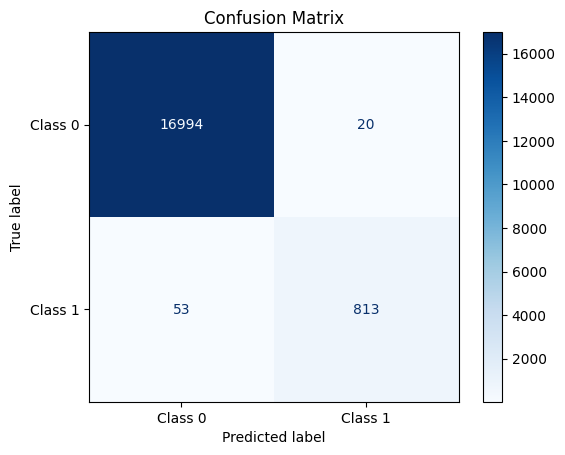

In [ ]:
# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(multi_model.state_dict(), "/content/drive/MyDrive/multimodal_model.pt")